![title](https://www.educafro.org.br/site/wp-content/uploads/2020/10/faculdade-insper-logo.png)

# APS Python para Ciência de Dados:

**Grupo:** Arthur Wachslicht, Gabriel Prado, Gustavo Salles, Luiz Felipe Souza e Pedro Osorio Magaldi Netto

**Link .zip no Drive:** https://drive.google.com/file/d/1csJ4jFuOCSIqGVKBEhwKKgE3E4M25O_O/view?usp=sharing

## Descrição das bases

O conjunto de bases de dados analisado contém dados históricos referentes às taxas cobradas por diversas faculdades americanas, além de outras informações sobre as instituições, como a quantidade de alunos, a diversidade da universidade e o salário esperado dos estudantes imediatamente após a formatura.

Por meio desta análise, buscamos entender as características das faculdades que levam a um maior ou menor salário esperado após a formatura. Para isso, iniciamos nosso estudo com uma análise descritiva, buscando entender a relação entre os fatores de forma visual. Feita essa análise, partimos para o desenvolvimento de diversos modelos, focando tanto em inferência quanto em capacidade preditiva. Utilizaremos os métodos de **regressão linear**, ***random forest*** e ***gradient boosted decision trees*** para desenvolver nossa análise, separando a base em treino e teste no processo, para garantir a confiabilidade das métricas dos modelos.

Seguem as bases utilizadas, assim como uma descrição das variáveis mais relevantes contidas nelas:

### `tuition_cost.csv`

Essa base contém o nome das universidades (*name*) e o estado em que se localizam (*state_name*), variáveis que se repetem em todas as outras bases e permitem fazer a correspondências dos dados. Além disso, essa base informa se a instituição é pública ou privada (*type*), além de diversas variáveis de custo para alunos em diferentes situações, como a taxa cobrada de alunos que moram no estado da universidade (*in_state_tuition*) e o custo para alunos que moram em outros estados (*out_of_state_tuition*).

|variable             |class     |description |
|:--------------------|:---------|:-----------|
|name                 |character |School name |
|state                |character | State name |
|state_code           |character | State Abbreviation |
|type                 |character | Type: Public, private, for-profit|
|degree_length        |character | 4 year or 2 year degree |
|room_and_board       |double    | Room and board in USD |
|in_state_tuition     |double    | Tuition for in-state residents in USD |
|in_state_total       |double    | Total cost for in-state residents in USD (sum of room & board + in state tuition) |
|out_of_state_tuition |double    | Tuition for out-of-state residents in USD|
|out_of_state_total   |double    | Total cost for in-state residents in USD (sum of room & board + out of state tuition) |

### `tuition_income.csv`

Essa base tem como variáveis adicionais relevantes o preço total médio de cursas a universidade (*total_price*), o preço médio realmente pago pelos alunos uma vez consideradas bolsas de estudos (*net_cost*) e uma variável categórica do nível de renda dos alunos (*income_lvl*).

|variable    |class     |description |
|:-----------|:---------|:-----------|
|name        |character | School name |
|state       |character | State Name |
|total_price |double    | Total price in USD |
|year        |double    | year |
|campus      |character | On or off-campus |
|net_cost    |double    | Net-cost - average actually paid after scholarship/award |
|income_lvl  |character | Income bracket |

### `salary_potential.csv`

Nessa base encontramos variáveis bastante relavantes para análise aqui apresentada, a saber o salário estimado médio em começo e meio de carreira para os alunos (*early_career_pay* e *mid_career_pay*, respectivamente), a porcentagem de alunos que acredita estar fazendo do mundo um lugar melhor (*make_world_better_percent*) e a porcentagem de alunos em trilhas de estudo de STEM (ciência, tecnologia, engenharia e matemática, *stem_percent*).

|variable                  |class     |description |
|:-------------------------|:---------|:-----------|
|rank                      |double    | Potential salary rank within state |
|name                      |character | Name of school |
|state_name                |character | state name |
|early_career_pay          |double    | Estimated early career pay in USD |
|mid_career_pay            |double    | Estimated mid career pay in USD |
|make_world_better_percent |double    | Percent of alumni who think they are making the world a better place |
|stem_percent              |double    | Percent of student body in STEM |

### `diversity_school.csv`

Por fim, essa base traz informações sobre diversidade nas universidade, classificando o corpo estudantil por grupos minoritários (*category*), como negros, asiáticos e estrangeiros, e fornecendo a porcentagem de alunos em cada categoria (*enrollment*).

|variable         |class     |description |
|:----------------|:---------|:-----------|
|name             |character | School name |
|total_enrollment |double    | Total enrollment of students |
|state            |character | State name |
|category         |character | Group/Racial/Gender category |
|enrollment       |double    | enrollment by category |

### Dicionário disponível em https://github.com/rfordatascience/tidytuesday/blob/master/data/2020/2020-03-10/readme.md

## Importando as bibliotecas necessárias:

In [1]:
import pandas as pd
from siuba import *
from plotnine import *
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

theme_set(theme_bw())

## Importando os dados:

In [2]:
tuition_cost = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-03-10/tuition_cost.csv')
tuition_income = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-03-10/tuition_income.csv')
salary_potential = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-03-10/salary_potential.csv')
historical_tuition = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-03-10/historical_tuition.csv')
diversity_school = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-03-10/diversity_school.csv')

## Análise descritiva

Para podermos fazer uma análise completa de nosso conjunto de dados, optamos primeiro por fazer uma análise descritiva, isto é, um sumário das informações contidas nos dados. Vejamos abaixo:

### Diversidade nas universidades:

In [3]:
diversity_percent = (diversity_school.dropna(subset=["name"]) >>
    spread(_.category, _.enrollment) >>
    transmute(_.name,
              pminority = _["Total Minority"] / _.total_enrollment,
              pforeign = _["Non-Resident Foreign"] / _.total_enrollment,
              pwomen = _["Women"] / _.total_enrollment))

### Número de estudante por categoria:

O primeiro passo foi obter informações relativas ao número absoluto de estudantes por categoria da base, que pode ser vista abaixo. Como podemos ver, a categoria mais representada em nossa base é a de mulheres, seguida pelos brancos, hispânicos e negros. *Total Minority* é o conjunto dos grupos minoritários raciais.

In [4]:
(diversity_school>>
    group_by(_.category)>>
    summarize(total_number=_.enrollment.sum()) >>
    arrange(-_.total_number))

,category,total_number
10,Women,11406332
9,White,10594649
6,Total Minority,7609693
3,Hispanic,3038062
2,Black,2623032
1,Asian,1152396
8,Unknown,1079537
5,Non-Resident Foreign,916832
7,Two Or More Races,595001
0,American Indian / Alaska Native,145875


### Porcentagem média de estudantes por categoria:

Em seguida, buscamos visualizar a representação de cada grupo por meio de um gráfico de barras. Como podemos ver, as mulheres compõe mais da metade do corpo estudantil analisado, assim como os brancos. Negros e hispânicos representam menos de 20% dos alunos cada, enquanto asiáticos, indígenas e outros grupos minoritários não chegam a 10% da população universitária.

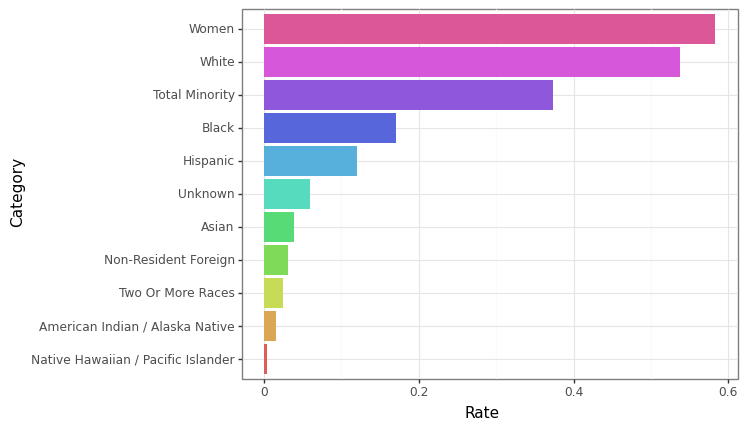

<ggplot: (166223896016)>

In [5]:
categories = (diversity_school >>
    mutate(rate=(_.enrollment/_.total_enrollment)) >>
    group_by(_.category)>>
    summarize(mean_rate=_.rate.mean()) >>
    arrange(_.mean_rate))["category"]

(diversity_school >>
    mutate(rate = (_.enrollment/_.total_enrollment),
           category = pd.Categorical(diversity_school["category"], categories = categories)) >>
    group_by(_.category) >>
    summarize(mean_rate=_.rate.mean()) >>
    ggplot(aes(x = "category", y = "mean_rate", fill = "category")) +
    geom_col(show_legend = False) +
    labs(x = "Category", y = "Rate") +
    coord_flip())

### Salário em começo de carreira X Salário em meio de carreira:

Aqui, podemos ver a relação esperada e intuitiva entre o salário no começo de carreira e o salário em meio de carreira. Evidentemente, aqueles que recebem salários maiores logo que se formam na universidade também recebem salários maiores posteriormente em suas carreiras, produzindo a relação linear bastante clara que vemos abaixo.

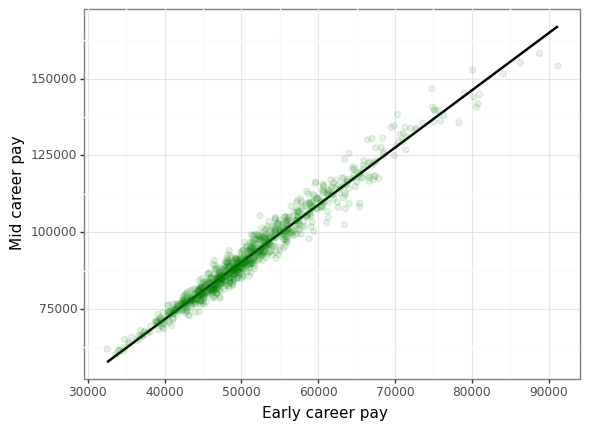

<ggplot: (166223895818)>

In [6]:
(salary_potential>>
    ggplot(aes(x="early_career_pay",y="mid_career_pay"))
    +labs(x="Early career pay",y="Mid career pay")
    +geom_smooth(color = "black", method = "lm", alpha = .5, se = False)
    +geom_point(color="green",size=2, alpha = .1))

### Instituições mais caras:

Buscamos também averiguar quais eram as instituições mais caras dentre as analisadas, como curiosidade. Optamos por selecionar as cinco instituições mais caras e expor o custo anual médio delas abaixo.

Neste item, observamos como há complexidade em analisar conjuntamente as universidades do nosso conjunto de dados, visto que são muito diversas em relação aos cursos disponibilizados. Neste caso, podemos ver como o preço de cursar a instituição de treinamento para aviação comercial foge consideravelmente do normal das outras universidades disponíveis na base de dados.

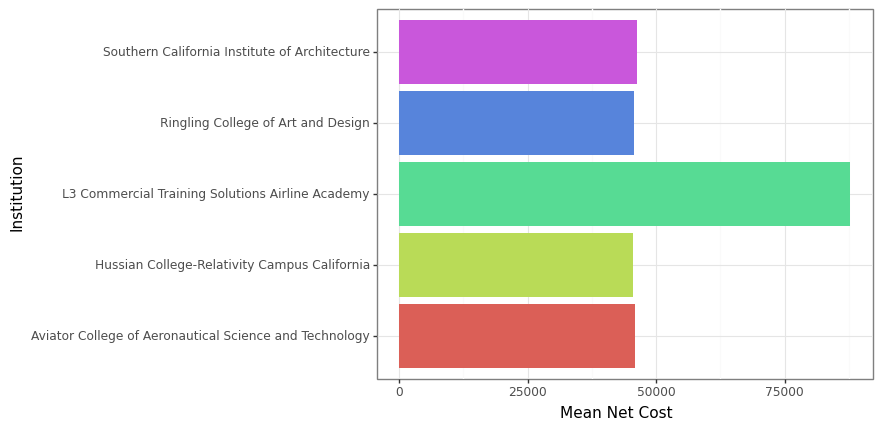

<ggplot: (166227642408)>

In [7]:
(tuition_income >> 
    group_by(_.name) >> 
    summarize(mean_net_cost=_.net_cost.mean())>>
    arrange(-_.mean_net_cost)>>
    head(5)>>
    ggplot(aes(x="name",y="mean_net_cost",fill="name"))
    +labs(x="Institution",y="Mean Net Cost",main="Most Expensive Universities")
    +geom_col(alpha=1,show_legend=False)
    +coord_flip())

### Porcentagem de alunos em STEM X Salário em meio de carreira:

Observada essa diferença nas mensalidade cobradas devido aos cursos fornecidos, consideramos que seria interessante analisar como os cursos afetam as perspectivas de salário dos alunos.

Podemos perceber como instituições com maior concentração de alunos da área de STEM (ciências, tecnologia, engenharia e matemática) apresentam maior salário médio em meio de carreira posteriormente, indicando que essas carreiras fornecem salários melhores.

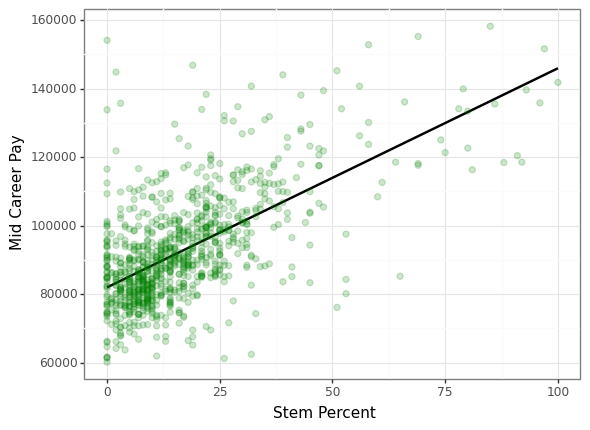

<ggplot: (166227642603)>

In [8]:
(salary_potential>>
    ggplot(aes(x="stem_percent",y="mid_career_pay"))
    +geom_smooth(color = "black", method = "lm", alpha = .5, se = False)
    +geom_point(color="green",size=2, alpha = .2)
    +labs(x="Stem Percent",y="Mid Career Pay"))

### Porcentagem de alunos que acredita fazer do mundo um lugar melhor X Salário em meio de carreira:

Neste caso, decidimos comparar a porcentagem de alunos que responderaam crer estar fazendo do mundo um lugar melhor com os salários em meio de carreira.

Apesar de grande dispersão aparente, podemos perceber que, no geral, o salário em meio de carreira está negativamente relacionado com a concentração de alunos que acreditam que estão tornando o mundo melhor na instituição. Neste caso, apesar de não nos aprofundarmos neste tema, surge interessante pergunta a ser respondida em outras análises - por que esta relação?

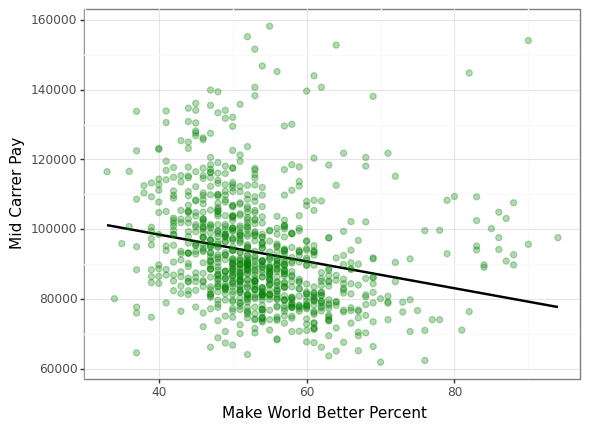

<ggplot: (166227644802)>

In [9]:
(salary_potential.dropna()>>
    ggplot(aes(x="make_world_better_percent",y="mid_career_pay"))+
    geom_smooth(color = "black", method = "lm", alpha = .5, se = False)+
    geom_point(color="green",size=2, alpha = .3)
    +labs(x="Make World Better Percent",y="Mid Carrer Pay"))

### Custo médio da universidade por nível de renda:

Adicionalmente, comparamos o custo médio da universidade com o nível de renda dos estudantes. Como esperado, quanto maior é o custo de médio, maior é o nível de renda dos alunos.

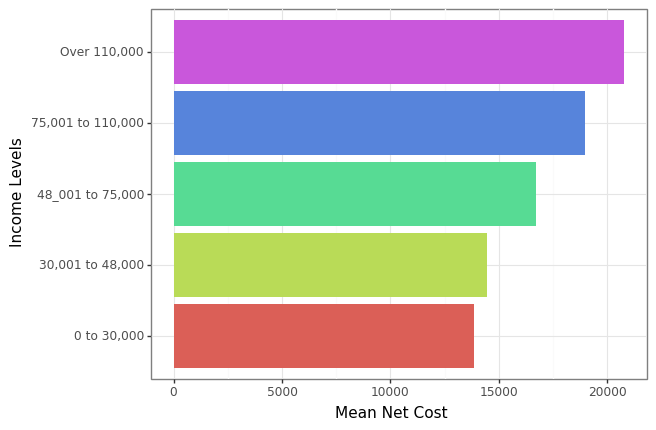

<ggplot: (166227668059)>

In [10]:
(tuition_income>>
      group_by(_.income_lvl)>>
      summarize(mean_net_cost=_.net_cost.mean())>>
      arrange(-_.mean_net_cost) >>
      ggplot(aes(x="income_lvl",y="mean_net_cost",fill="income_lvl"))+
      labs(x="Income Levels",y="Mean Net Cost",main="Mean Net Cost per Income Level")+
      geom_col(alpha=1, show_legend = False)+
      coord_flip())

### Médias salariais por estado:

De forma interessante, ao observar o salário médio por estado na base de dados, não encontramos os estados mais famosos no topo, como a Califórnia e Nova Iorque, nem mesmo os estados famosos por universidades prestigiosas, como Massachussetts.

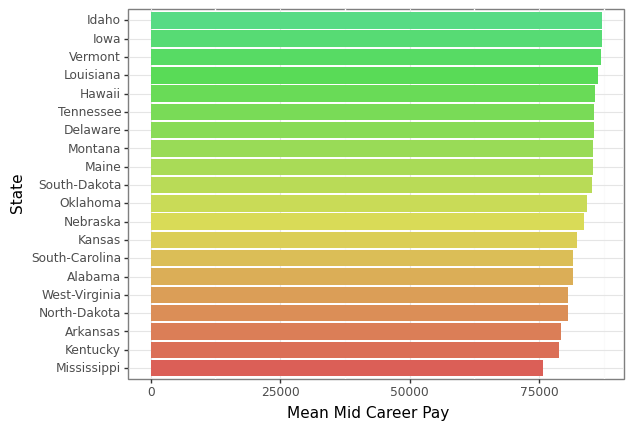

<ggplot: (166227734923)>

In [11]:
categories = (salary_potential >>
    group_by(_.state_name) >>
    summarize(mean_mid_career_pay=_.mid_career_pay.mean()) >>
    arrange(_.mean_mid_career_pay))["state_name"]

(salary_potential >>
    mutate(state_name = pd.Categorical(salary_potential["state_name"], categories = categories)) >>
    group_by(_.state_name) >>
    summarize(mean_mid_career_pay=_.mid_career_pay.mean()) >>
    head(20) >>
    ggplot(aes(x = "state_name", y = "mean_mid_career_pay", fill = "state_name")) +
    geom_col(alpha=1, show_legend = False) +
    labs(x = "State", y = "Mean Mid Career Pay") +
    coord_flip())

### Média de porcentagem de alunos em STEM por estado:

No entanto, quando olhamos a porcentagem média de alunos de STEM por estado, encontramos justamente os estados que esperávamos na análise anterior, a saber Nova York, Califórnia e Massachussetts.

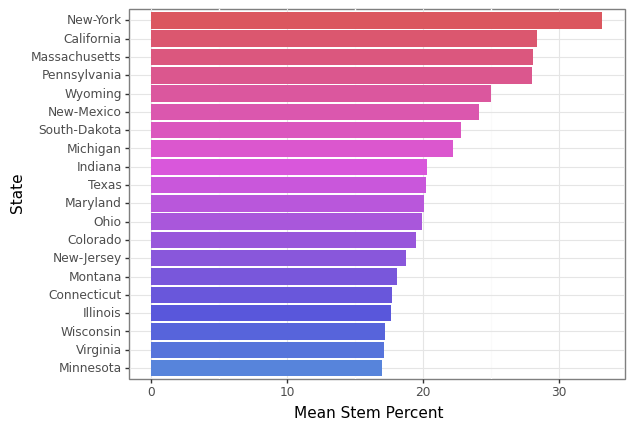

<ggplot: (166227758538)>

In [12]:
categories = (salary_potential >>
                group_by(_.state_name)>>
                summarize(mean_stem_percent=_.stem_percent.mean())>>
                arrange(_.mean_stem_percent))["state_name"]

(salary_potential >>
    mutate(state_name = pd.Categorical(salary_potential["state_name"], categories = categories)) >>
    group_by(_.state_name) >>
    summarize(mean_stem_percent=_.stem_percent.mean()) >>
    arrange(-_.mean_stem_percent) >>
    head(20) >>
    ggplot(aes(x = "state_name", y = "mean_stem_percent", fill = "state_name")) +
    geom_col(show_legend = False) +
    labs(x = "State", y = "Mean Stem Percent") +
    coord_flip())

### Custo de moradia por estado:

Abaixo vemos os estados com maiores custos de moradia, considerando o custo médio para os alunos.

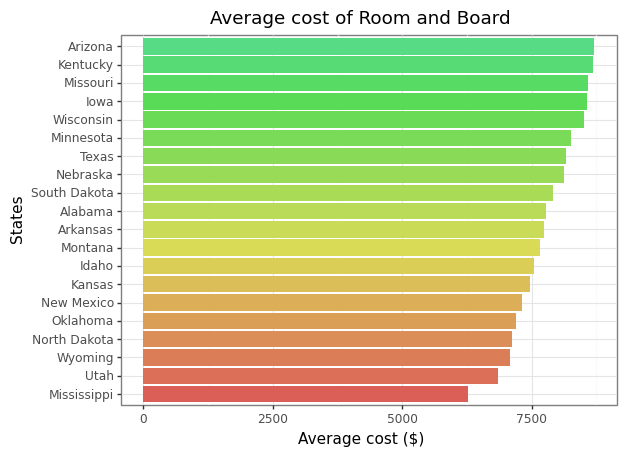

<ggplot: (166224974608)>

In [13]:
theme_set(theme_bw())

order_states = (tuition_cost >>
                group_by(_.state) >>
                summarize(avg_room_board = _.room_and_board.mean()) >>
                arrange(_.avg_room_board))["state"]

(tuition_cost >>
    mutate(state = pd.Categorical(tuition_cost["state"], categories=order_states)) >>
    group_by(_.state) >>
    summarize(avg_room_board = _.room_and_board.mean()) >>
    head(20) >>
    ggplot(aes("state", "avg_room_board")) +
    geom_col(aes(fill = "state"), show_legend = False) +
    coord_flip() +
    labs(x = "States",
         y = "Average cost ($)",
         title = "Average cost of Room and Board"))

### Estados com as maiores porcentagens médias de alunos brancos:

Neste caso, observamos quais os estados com as maiores porcentagens médias de alunos brancos nas universidades.

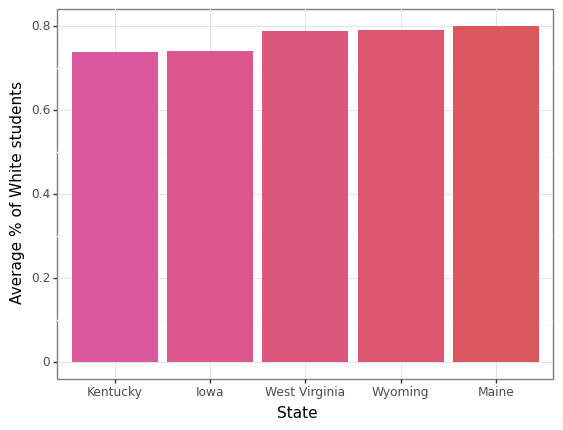

<ggplot: (166225237517)>

In [14]:
order_states = (diversity_school >>
                mutate(rate = (_.enrollment / _.total_enrollment)) >>
                group_by(_.state, _.category) >>
                summarize(mean_rate = _.rate.mean()) >>
                filter(_.category == "White") >>
                arrange(_.mean_rate))["state"]

(diversity_school>>
        mutate(rate = (_.enrollment / _.total_enrollment),
               state = pd.Categorical(diversity_school["state"], categories = order_states)) >>
        group_by(_.state,_.category) >>
        summarize(mean_rate = _.rate.mean()) >>
        filter(_.category == "White") >>
        arrange(-_.mean_rate) >>
        head(5) >>
        ggplot(aes(x = "state", y = "mean_rate", fill = "state")) +
        labs(x = "State", y = "Average % of White students") +
        geom_col(alpha = 1, show_legend = False))

### Estados com as menores porcentagens médias de alunos brancos:

De maneira análoga, observamos quais os estados com as menores porcentagens médias de alunos brancos nas universidade. Notadamente, o Havaí é o estado com menor porcentagem de alunos brancos, o que pode ser explicado por sua populacão nativa. Além disso, observamos estados com grande número de imigrantes, como Flórida e Califórnia.

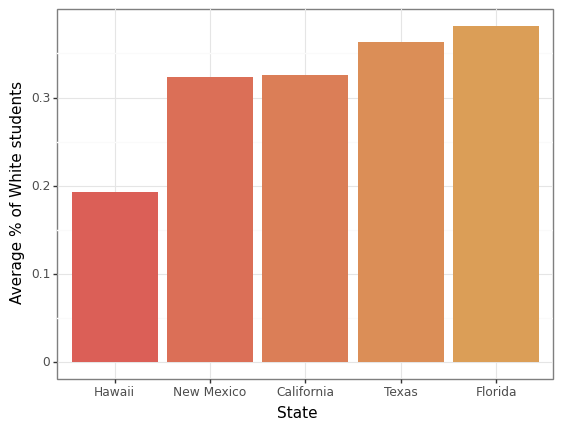

<ggplot: (166224577799)>

In [15]:
order_states = (diversity_school >>
                mutate(rate = (_.enrollment / _.total_enrollment)) >>
                group_by(_.state, _.category) >>
                summarize(mean_rate = _.rate.mean()) >>
                filter(_.category == "White") >>
                arrange(_.mean_rate))["state"]

(diversity_school>>
        mutate(rate=(_.enrollment/_.total_enrollment),
               state = pd.Categorical(diversity_school["state"], categories = order_states))>>
        group_by(_.state,_.category)>>
        summarize(mean_rate=_.rate.mean())>>
        filter(_.category=="White")>>
        arrange(_.mean_rate)>>
        head(5)>>
        ggplot(aes(x="state",y="mean_rate",fill="state"))+
        labs(x="State",y="Average % of White students")+
        geom_col(alpha=1, show_legend = False))

## Análise

### Relações entre diversidade e salário de início de carreira:

Então prosseguimos para análises dos salários potenciais dos alunos quando à luz da diversidade.

#### Diversidade de gênero

Aqui, juntamos duas análises em um gráfico. Em vermelho, temos a relação entre os salários em começo de carreira e a porcentagem de mulheres nas universidades; em azul, temos a relação entre os salários em meio de carreira e a porcentagem de mulheres nas universidades.

A grande disperção dos dados aparente nas faixas fora dos 50% a 75% de mulheres na instituição torna ineficiente a análise visual da relação, mas podemos observar que há certa tendência de universidades com maiores concentrações de mulheres apresentarem menores salários do que as com maiores concentrações de homens, o que é esperado dado que as mulheres recebem, em média, salários menores do que os homens.

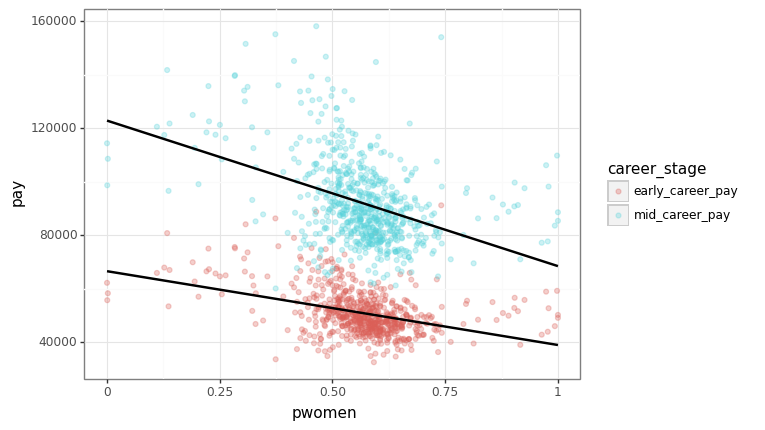

<ggplot: (166224583440)>

In [16]:
(salary_potential >>
    inner_join(_, diversity_percent, on = "name") >>
    gather("career_stage", "pay", _["early_career_pay", "mid_career_pay"]) >>
    ggplot(aes("pwomen", "pay", color = "career_stage")) +
    geom_point(alpha = .3) +
    geom_smooth(aes(group = "career_stage"), method = "lm", se = False, color = "black"))

#### Diversidade em geral

Aqui, pudemos ver que aparentemente diversidade de forma absoluta não se relaciona muito com os salários após a universdiade. Há duas interpretações mais plausíveis para esse fenômeno. A mais simples é a que não existe efeito nenhum. No entanto, sabemos que membros de grupos minoritários recebem salários menores, em média. O fato de que o gráfico de dispersão não indica essa relação pode ser indicativo de que há um efeito positivo da diversidade no salário anulando o outro efeito. Seja como for, a análise abaixo não é suficiente para responder essas perguntas ou destrinchar a rede causal desse fenômeno.

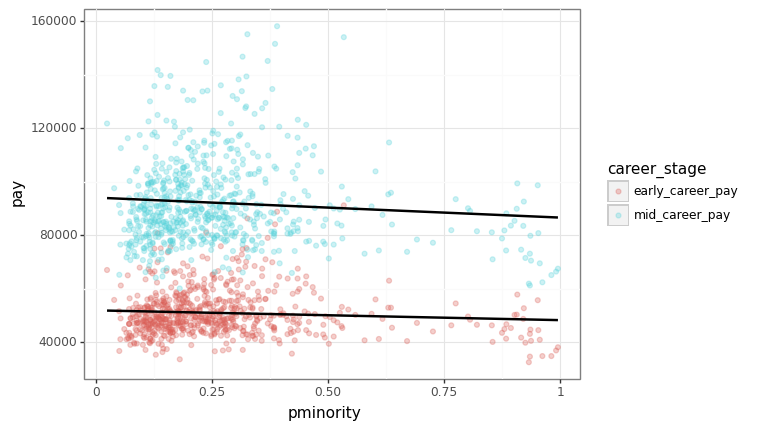

<ggplot: (166224563312)>

In [17]:
(salary_potential >>
    inner_join(_, diversity_percent, on = "name") >>
    gather("career_stage", "pay", _["early_career_pay", "mid_career_pay"]) >>
    ggplot(aes("pminority", "pay", color = "career_stage")) +
    geom_point(alpha = .3) +
    geom_smooth(aes(group = "career_stage"), method = "lm", se = False, color = "black"))

#### Diversidade de estrangeiros

Por sua vez, achamos interessante a relação entre a porcentagem de estrangeiros na instituição e os salários, porém há muita concentração de dados na faixa inicial, o que faz com que a linha de tendência teórica não seja muito eficiente. Ou seja, a baixa presença de estrangeiros nas universidades americanas prejudica nossa análise de seu efeito nos salários.

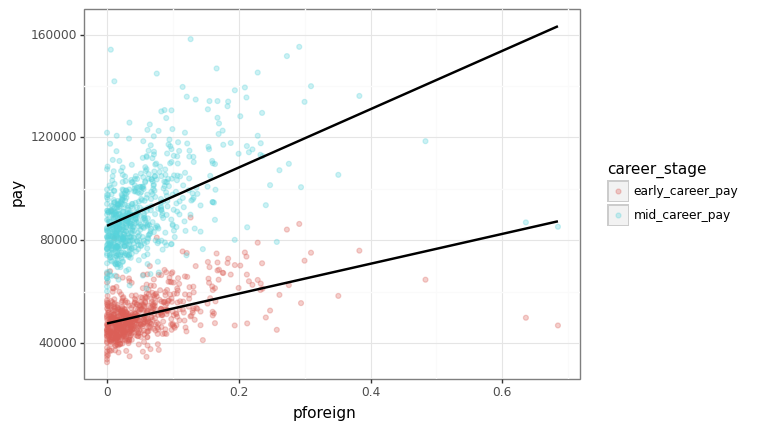

<ggplot: (166227736971)>

In [18]:
(salary_potential >>
    inner_join(_, diversity_percent, on = "name") >>
    gather("career_stage", "pay", _["early_career_pay", "mid_career_pay"]) >>
    ggplot(aes("pforeign", "pay", color = "career_stage")) +
    geom_point(alpha = .3) +
    geom_smooth(aes(group = "career_stage"), method = "lm", se = False, color = "black"))

### Regressão linear para propósitos de inferência do salário em meio de carreira:

Dado que o salário em meio de carreira é altamente correlacionado com o salário no começo de carreira e, ainda assim, mais indicativo da capacidade produtiva geral do aluno, decidimos fazer uma regressão que busca explicar o salário em meio de carreira usando como variáveis explicativas a porcentagem de alunos que afirma acreditar fazer do mundo um lugar melhor e a porcentagem de alunos em matérias de STEM.

$$ \large{ {Y}_{i} = \beta_{0} + \beta_{1} \ln{{X}_{1i}} + \beta_{2} {X}_{2i} + \epsilon_{i}} $$
$${}$$
$${}$$
$$ \begin{split}
{Y}_{i} &=\texttt{Salário em meio de carreira}\\
{X}_{1i} &=\texttt{Porcentagem que acredita melhorar o mundo}\\
{X}_{2i} &=\texttt{Porcentagem em STEM} 
\end{split}$$

In [19]:
lin_reg = smf.ols("mid_career_pay ~ np.log(make_world_better_percent) + stem_percent", salary_potential).fit()
lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         mid_career_pay   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.414
Method:                 Least Squares   F-statistic:                     318.9
Date:                Mon, 30 Nov 2020   Prob (F-statistic):          2.12e-105
Time:                        22:03:52   Log-Likelihood:                -9749.3
No. Observations:                 902   AIC:                         1.950e+04
Df Residuals:                     899   BIC:                         1.952e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                          1.352e+05      1e+04     13.457      0.000    1.15e+05    1.55e+05
np.log(make_world_better_percent) -1.331e+04   2502.304     -5.320      0.000   -1.82e+04   -8400.718
stem_percent                        626.4771     26.939     23.256      0.000     573.607     679.347
==============================================================================
Omnibus:                      219.140   Durbin-Watson:                   1.064
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              813.333
Skew:                           1.118   Prob(JB):                    2.44e-177
Kurtosis:                       7.080   Cond. No.                         600.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Como podemos ver, as duas variáveis utilizadas no modelo se mostraram significativas para explicar o salário médio em meio de carreira, porém com sinais opostos.

Para a variável *make_world_better_percent*, obtivemos uma correlação negativa, indicando que uma maior proporção de alunos que acreditam fazer do mundo um lugar melhor leva a salários menores. Como hipótese causal para esse achado, podemos apontar a possibilidade de que os alunos que acreditam poder melhorar o mundo procuram carreiras menos lucrativas.

A variável *stem_percent*, que indica a porcentagem de alunos em carreiras de STEM, mostrou, por sua vez, correlação positiva. Esse resultado também já era esperado dada nossa análise descritiva, que indicava maiores salários para os alunos dessas áreas do conhecimento.

### Regressão linear para previsão do salário em meio de carreira:

Para realizarmos um modelo mais voltado à predição buscamos garantir que as métricas de avaliação do modelo sejam as mais confiáveis possíveis. Para isso, separamos a base de dados original em uma porção de treino e outra de teste, de forma que as métricas de qualidade dos modelos sejam coletadas em uma parcela dos dados não utilizada no treino deste.

In [20]:
train, test = train_test_split(salary_potential.dropna(), test_size = 0.7, random_state = 1234) 

lm = smf.ols("mid_career_pay ~ np.log(make_world_better_percent) + stem_percent", data = train).fit()

lm_hat = lm.predict(test)
print("RMSE:", np.sqrt(mean_squared_error(test.mid_career_pay, lm_hat)).round(2), "\n")
print("R-squared:", r2_score(test.mid_career_pay, lm_hat).round(4))

RMSE: 12519.54 

R-squared: 0.3652


Utilizamos, nesta etapa, o mesmo modelo utilizado previamente - o de regressão linear - para fazer nossas previsões, método baseado na metodologia OLS para chegar a seus resultados. Obtemos um resultado razoável, com 36.52% de R-quadrado e 6693.72 de raiz do erro quadrático médio. O R-quadrado, essencialmente, indica a correlação entre os resultados previstos e os dados observados, sendo 34% um bom resultado para o modelo analisado, aparentemente. Já o RMSE mede o desvio médio entre o resultado previsto e o observado. Como o valor é de 12519.54, dado que a variância da variáveis prevista é de 15856.48, o erro parece ser razoável.

### Modelo *Random Forest* para previsão:

Buscando um melhor resultado para as previsões, rodamos também um modelo de *Random Forest*, modelo este baseado em árvores de decisão que consegue excelentes resultados por meio do processo de *bagging*.

In [21]:
salary_diversity = (salary_potential >>
                    inner_join(_, diversity_percent, on = "name") >>
                    inner_join(_, tuition_cost >>
                                  select(_.name, _.type), on = "name"))

y, X = patsy.dmatrices("mid_career_pay ~ 0 + np.log(make_world_better_percent) + stem_percent + \
                        state_name + pminority + pforeign + pwomen + type", data = salary_diversity)

X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size = 0.7, random_state = 1234)

rf = RandomForestRegressor(n_estimators=500)
rf.fit(X_trn, y_trn.ravel())

rf_hat = rf.predict(X_tst)
print("RMSE:", np.sqrt(mean_squared_error(y_tst, rf_hat)).round(2), "\n")
print("R-squared:", r2_score(y_tst, rf_hat).round(4))

RMSE: 10259.5 

R-squared: 0.5599


Além de um RMSE menor, o R-quadrado do método *Random Forest* se mostrou muito melhor do que na regressão linear. Isso pode resultar de resultados em geral mais condizentes com os valores observados, representando um melhor modelo em relação ao de regressão linear.

### *Boosted Decision Tree* para previsão:

Como um último modelo preditivo, utilizamos a técnica de *Boosting* para regressão. Esse método treina, de forma sequencial, diversas árvores de regressão, utilizando o erro quadrático médio como função de perda e treinando as próximas árvores nos erros das árvores anteriores. Esse método apresentou resultados marginalmente piores em relação aos resultados do método de Random Forest, mas ainda melhores do que os resultados do modelo de regressão linear. Dessa forma, recomendaríamos a utilização de um modelo de Random Forest para a previsão de valores no contexto deste problema.

In [22]:
salary_diversity = (salary_potential >>
                    inner_join(_, diversity_percent, on = "name") >>
                    inner_join(_, tuition_cost >>
                                  select(_.name, _.type), on = "name"))

y, X = patsy.dmatrices("mid_career_pay ~ 0 + np.log(make_world_better_percent) + stem_percent + \
                        state_name + pminority + pforeign + pwomen + type", data = salary_diversity)

X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size = 0.7, random_state = 1234)

boost = GradientBoostingRegressor(learning_rate = 0.01, n_estimators = 200)
boost.fit(X_trn, y_trn.ravel())

boost_hat = boost.predict(X_tst)
print("RMSE:", np.sqrt(mean_squared_error(y_tst, boost_hat)).round(2), "\n")
print("R-squared:", r2_score(y_tst, boost_hat).round(4))

RMSE: 10969.0 

R-squared: 0.497


### Regressão linear para propósitos de inferência do salário em meio de carreira (mais variáveis):

Decidimos então adicionar variáveis a nossa regressão linear, buscando resultados mais controlados. Consideramos então que o custo médio de frequentar a universidade e o tipo de universidade (pública ou particular) são variáveis essenciais para controlar os fatores causais.

$$ \large{ \ln{{Y}_{i}} = \beta_{0} + \beta_{1} \ln{{X}_{1i}} + \beta_{2} {X}_{2i} + \beta_{3} {X}_{3i} + \beta_{4} {X}_{4i} + \epsilon_{i}} $$
$${}$$
$${}$$
$$ \begin{split}
{Y}_{i} &=\texttt{Salário em meio de carreira}\\
{X}_{1i} &=\texttt{Porcentagem que acredita melhorar o mundo}\\
{X}_{2i} &=\texttt{Porcentagem em STEM}\\
{X}_{3i} &=\texttt{Custo médio da universidade}\\
{X}_{4i} &=\texttt{Tipo da universidade (pública ou privada)}
\end{split}$$

In [23]:
tuition_salary = (tuition_income >>
                  inner_join(_, salary_potential, on = "name") >>
                  inner_join(_, tuition_cost >>
                                    transmute(_.name, _.type,
                                    public = _.type == "Public",
                                    private = _.type == "Private",
                                    boolean = _.public | _.private) >>
                                    filter(_.boolean) >>
                                    select(_["name", "type"]), on = "name"))

lin_reg = smf.ols("mid_career_pay ~ np.log(make_world_better_percent) + stem_percent + net_cost + type", tuition_salary).fit()
lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         mid_career_pay   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.517
Method:                 Least Squares   F-statistic:                 1.422e+04
Date:                Mon, 30 Nov 2020   Prob (F-statistic):               0.00
Time:                        22:03:54   Log-Likelihood:            -5.6592e+05
No. Observations:               53053   AIC:                         1.132e+06
Df Residuals:                   53048   BIC:                         1.132e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                           1.77e+05   1262.607    140.158      0.000    1.74e+05    1.79e+05
type[T.Public]                    -2908.2989    107.598    -27.029      0.000   -3119.191   -2697.407
np.log(make_world_better_percent)  -2.49e+04    305.936    -81.398      0.000   -2.55e+04   -2.43e+04
stem_percent                        589.6350      3.072    191.943      0.000     583.614     595.656
net_cost                              0.2424      0.007     36.392      0.000       0.229       0.255
==============================================================================
Omnibus:                    11429.916   Durbin-Watson:                   0.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            49784.277
Skew:                           1.000   Prob(JB):                         0.00
Kurtosis:                       7.304   Cond. No.                     6.13e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.13e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Pode-se observar que, mais uma vez, todas as variáveis mostraram-se significativas.

De especial relevância para nossa análise é que tanto o coeficiente da porcentagem de alunos que acreditam fazer do mundo um lugar melhor quanto o coeficiente da porcentagem de alunos em STEM mostraram mesmo sinal quando comparados aos coeficientes da regressão linear anterior. Tampouco mostraram mudança de ordem de grandeza.

Com esse novo resultado, então, mantemos as inferências feitas anteriormente, em que acreditar em um mundo melhor representa um menor salário esperado e cursar STEM representa um maior salário esperado.

Além disso, obtivemos o resultado de que as universidade de maior custo são também aquelas com maiores salários posteriormente. Esse resultado é esperado dado que havíamos observado que as universidade com maiores custos reuniam também os alunos de maior nível de renda, condição social de suas fafílias que se reflete em seus salários futuros. Essa relação indica a importância de usar essa variável como controle, mas, como apontado, ela não alterou de forma expressiva nossos resultados e inferências.

### Regressão linear para propósitos de inferência da porcentagem de alunos que acredita fazer do mundo um lugar melhor:

Por fim, decidimos analisar a interação da porcentagem de alunos que acredita fazer do mundo um lugar melhor com as outras variáveis. Para isso, utilizamos a seguinte regressão linear.

$$ \large{ \ln{{Y}_{i}} = \beta_{0} + \beta_{1} {{X}_{1i}} + \beta_{2} {X}_{2i} + \beta_{3} {X}_{3i} + \epsilon_{i}} $$
$${}$$
$${}$$
$$ \begin{split}
{Y}_{i} &=\texttt{Porcentagem que acredita melhorar o mundo}\\
{X}_{1i} &=\texttt{Custo médio da universidade}\\
{X}_{2i} &=\texttt{Tipo da universidade (pública ou privada)}\\
{X}_{3i} &=\texttt{Porcentagem em STEM}\\
\end{split}$$

In [24]:
tuition_salary = (tuition_income >>
                  inner_join(_, salary_potential, on = "name") >>
                  inner_join(_, tuition_cost >>
                                    transmute(_.name, _.type,
                                    public = _.type == "Public",
                                    private = _.type == "Private",
                                    boolean = _.public | _.private) >>
                                    filter(_.boolean) >>
                                    select(_["name", "type"]), on = "name"))

lin_reg = smf.ols("np.log(make_world_better_percent) ~ net_cost + type + stem_percent", tuition_salary).fit()
lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                   
=============================================================================================
Dep. Variable:     np.log(make_world_better_percent)   R-squared:                       0.070
Model:                                           OLS   Adj. R-squared:                  0.070
Method:                                Least Squares   F-statistic:                     1330.
Date:                               Mon, 30 Nov 2020   Prob (F-statistic):               0.00
Time:                                       22:03:54   Log-Likelihood:                 26306.
No. Observations:                              53053   AIC:                        -5.260e+04
Df Residuals:                                  53049   BIC:                        -5.257e+04
Df Model:                                          3                                         
Covariance Type:                           nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          4.0910      0.002   1732.219      0.000       4.086       4.096
type[T.Public]    -0.0252      0.002    -16.538      0.000      -0.028      -0.022
net_cost         -4.7e-06   9.23e-08    -50.915      0.000   -4.88e-06   -4.52e-06
stem_percent      -0.0014   4.32e-05    -33.156      0.000      -0.002      -0.001
==============================================================================
Omnibus:                      484.676   Durbin-Watson:                   0.069
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              627.579
Skew:                           0.146   Prob(JB):                    5.28e-137
Kurtosis:                       3.445   Cond. No.                     8.66e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.66e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Observa-se aqui também que todas as variáveis utilizadas apresentaram coeficientes significativos para explicar a porcentagem de alunos que acredita fazer do mundo um lugar melhor.

Destacamos o fato de que o custo médio da universidade está negativamente correlacionado com essa porcentagem, indicando que universidade mais baratas apresentam um maior número de alunos que acreditam melhorar o mundo. É importante notar que esse efeito não se dá pelo fato das universidade públicas serem em geral mais baratas, dado que usamos o tipo da instituição como controle.

De especial importância nesse relatório é o fato de que a porcentagem de alunos em STEM mostra relação negativa com a porcentagem de alunos que acredita fazer do mundo um lugar melhor. Esse resultado se encaixa, embora não seja decorrência necessária, com o fato de que essas duas variáveis mostravam sinais trocados em relação aos salários em meio de carreira.

## Conclusões

Por meio deste trabalho, o grupo pode aprender e consolidar uma série de técnicas de ciência de dados usando *python*. Aprimoramos nossas habilidade de criação de análises visuais de dados e desenvolvemos nossa capacidade de fazer inferências e previsões usando *python*. Acreditamos ter construído modelos preditivos robustos e modelos inferenciais que permitem entender o perfil dos estudantes nas universidades americans. Como conclusões mais significativas, destacamos a relação positiva entre a porcentagem de alunos em STEM e os salários e a relação negativa entre a porcentagem de alunos que acreditam fazer do mundo um lugar melhor e os salários.